**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Trabajo Práctico:** 2

**Datos de la entrega:** Jueves 17 de octubre 2024, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo comprimido con todos los archivos de su solución a este Trabajo Práctico. En caso de requerir mucho espacio, solicitarle al profesor una carpeta en One-Drive para subir la solución.

---

**Estudiantes:**
- Andrey Arguedas Espinoza - 2020426569

# Entregable 1.  Experimentación en Image Colorization

1. El objetivo central es investigar y experimentar en el uso de Deep Learning para la tarea de Image Colorization. En particular pasar de imágenes en escala de grises a imágenes a color.
1. Como dataset puede utilizar ImageWoof (https://docs.ultralytics.com/es/datasets/classify/imagewoof/#dataset-variants)  u otro de su elección. Sobre todo considerando la capacidad de procesamiento de que disponga.
1. Puede usar una biblioteca como OpenCV para obtener las imágenes en escala de grises, o incluso pasar las imágenes iniciales de RGB al espacio de color CIE LAB (el canal L le servirá).
1. Usted debe proponer e implementar el Diseño Experimental, el cual debe considerar al menos tres arquitecturas: dos existentes y una tercer arquitectura propuesta por Usted, no es problema que sea alguna de las dos primeras con algún cambio propuesto por Usted. Es requisito que se programen las capas requeridas para la red neuronal artificial, no usar frameworks que con la llamada a una función retornen el resultado.
1. Es válido utilizar código de alguna fuente como base, pero debe ser citada claramente la fuente.

## • Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner as kt
import seaborn as sns
import wandb
import cv2
import tensorflow_io as tfio
from collections import defaultdict

from PIL import Image
from tensorflow import keras
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization


### • Define global size for all our images, we will use this dimensions across our project, it also helps to reduce the resources needed to run the project and unifies the size of all images since in this dataset the images size is not unified

### • Define global batch size for the project, loading and training

In [2]:
images_dimensions = (120, 120)
reshapable_dimension = (120, 120, 1)
local_batch_size = 64

## • Load Dataset

In [3]:
# Load the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './imagewoof2-160/train',
    batch_size=local_batch_size,  # Batch size
    image_size=images_dimensions,  # Resize images to the required input size for your model
)

# Load the training dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './imagewoof2-160/val',
    batch_size=local_batch_size,  # Batch size
    image_size=images_dimensions,  # Resize images to the required input size for your model
)


Found 9025 files belonging to 10 classes.
Found 3929 files belonging to 10 classes.


## • Visualize a few images from training to see they are loading correctly

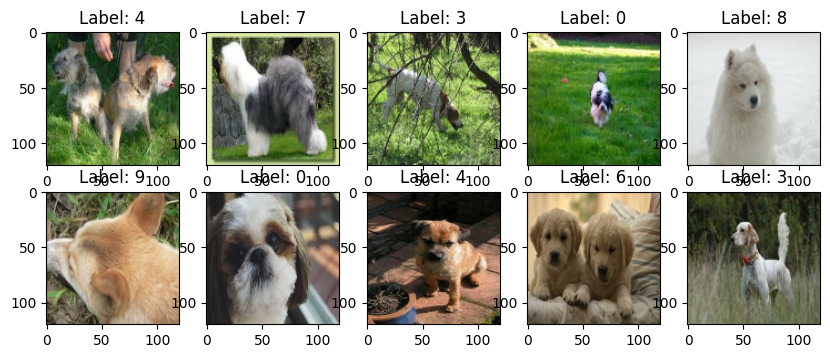

In [4]:
# Take the first batch from the dataset
for images, labels in train_dataset.take(1):  # Extract 1 batch (typically 32 samples)
    break  # You only need one batch

# Visualize the first 10 images in the batch
plt.figure(figsize=(10, 10))  # Set the figure size

for i in range(10):  # Loop through the first 10 images
    ax = plt.subplot(5, 5, i + 1)  # Create a 5x5 grid for displaying images
    plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to numpy and display
    plt.title(f"Label: {labels[i].numpy()}")  # Show the label

plt.show()  # Display the images

## • Now we will convert our training dataset to the CIELAB color space

In [5]:
# Convert RGB image to Lab color space
def rgb_to_lab(image, label):
    normalized_image = image / 255.0
    lab_img = tfio.experimental.color.rgb_to_lab(normalized_image)
    return lab_img, label

# Apply the preprocessing function to the dataset
train_dataset = train_dataset.map(rgb_to_lab)


## • Now we can plot a few images of our training dataset to the CIELAB color space

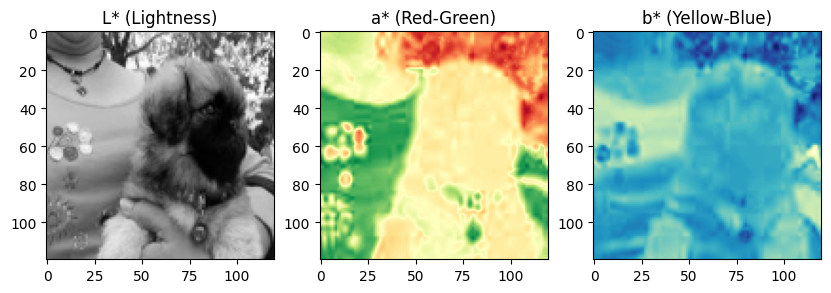

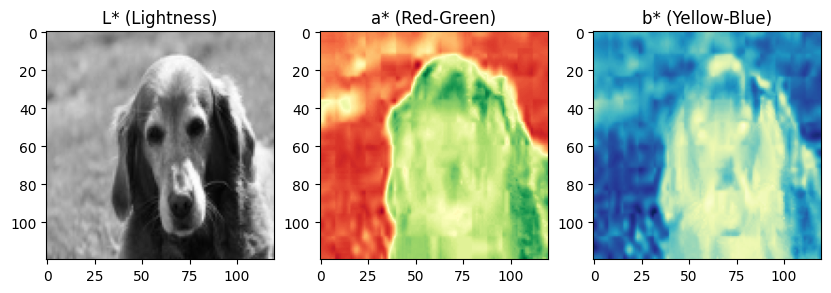

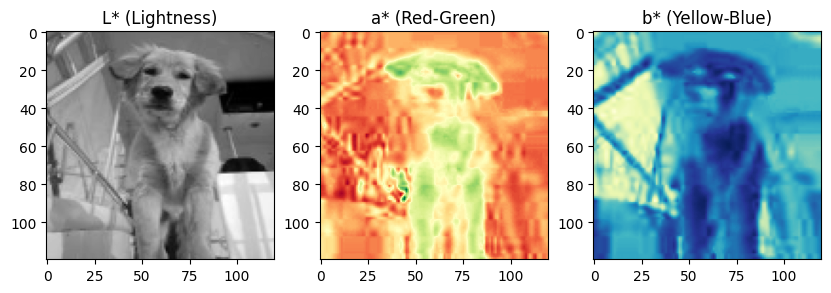

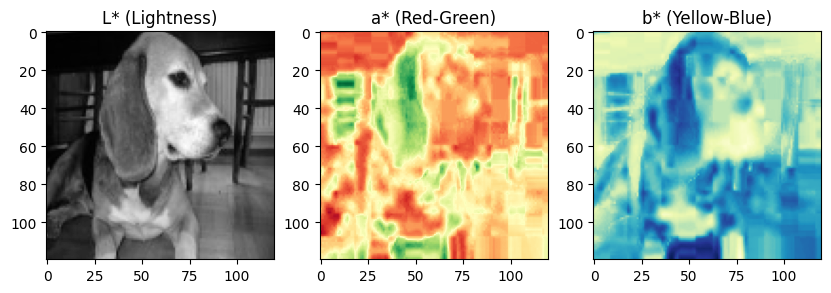

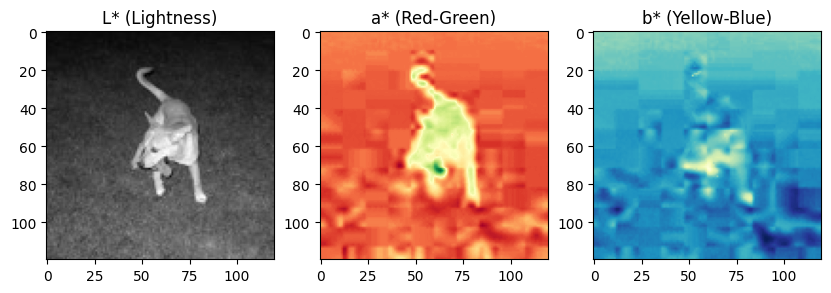

In [6]:
# Take the first batch from the dataset
for images, labels in train_dataset.take(1):  # Extract 1 batch (typically 32 samples)
    break  # You only need one batch

for i in range(5):
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    image_lab = images[i]
    
    axs[0].imshow(image_lab[:, :, 0], cmap='gray')
    axs[0].set_title('L* (Lightness)')

    axs[1].imshow(image_lab[:, :, 1], cmap='RdYlGn')
    axs[1].set_title('a* (Red-Green)')

    axs[2].imshow(image_lab[:, :, 2], cmap='YlGnBu')
    axs[2].set_title('b* (Yellow-Blue)')
    
plt.show()


### Lets build and split dataset

In [7]:
train_dataset = train_dataset.unbatch()
train_images = np.asarray(list(train_dataset.map(lambda x, y: x)))
train_labels = np.asarray(list(train_dataset.map(lambda x, y: y)))

print("Shape of train images", train_images.shape)

Shape of train images (9025, 120, 120, 3)


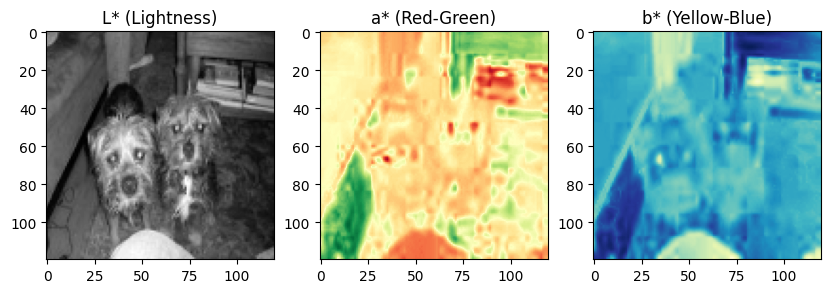

In [8]:
for i in range(1):
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    image_lab = train_images[i]
    
    axs[0].imshow(image_lab[:, :, 0], cmap='gray')
    axs[0].set_title('L* (Lightness)')

    axs[1].imshow(image_lab[:, :, 1], cmap='RdYlGn')
    axs[1].set_title('a* (Red-Green)')

    axs[2].imshow(image_lab[:, :, 2], cmap='YlGnBu')
    axs[2].set_title('b* (Yellow-Blue)')
    
plt.show()

In [9]:
#Images only with grayscale channel
X = train_images[:, :, :, 0] / 255.0
print(X.shape)
print(X[0])

#Images with AB channels
y = train_images[:, :, :, 1:] / 128.0
print(y.shape)
print(y[0])

(9025, 120, 120)
[[0.18387063 0.18060341 0.17835702 ... 0.06645179 0.06753503 0.06840698]
 [0.18217964 0.18088607 0.1914075  ... 0.07183479 0.06764176 0.06227583]
 [0.19568215 0.20910788 0.18925686 ... 0.08070248 0.07161204 0.06381276]
 ...
 [0.14516881 0.14260279 0.14592507 ... 0.18448181 0.20196174 0.20469172]
 [0.15040492 0.13995184 0.14937791 ... 0.20288119 0.1964407  0.18135881]
 [0.14029431 0.15114562 0.14607404 ... 0.2090481  0.17983554 0.16637693]]
(9025, 120, 120, 2)
[[[ 0.02795295  0.08805254]
  [ 0.02936227  0.08398248]
  [ 0.0294887   0.08419631]
  ...
  [ 0.13412896  0.18314731]
  [ 0.11821592  0.17802413]
  [ 0.11831743  0.17489043]]

 [[ 0.02804655  0.08821794]
  [ 0.0287313   0.08615069]
  [ 0.02874434  0.08312622]
  ...
  [ 0.1341498   0.19648674]
  [ 0.12385996  0.1862357 ]
  [ 0.1269381   0.17610312]]

 [[ 0.02733152  0.0869384 ]
  [ 0.02668751  0.08575255]
  [ 0.02881745  0.08345526]
  ...
  [ 0.1364227   0.21308102]
  [ 0.13235095  0.19978164]
  [ 0.1345639   0.188

In [10]:
# Define the CNN model
def create_colorization_model(input_shape=reshapable_dimension):
    model = models.Sequential()

    # Encoder
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))  # Fewer filters
    model.add(layers.BatchNormalization())  # Added BatchNorm
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())  # Added BatchNorm
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Bottleneck
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))  # Smaller bottleneck
    model.add(layers.BatchNormalization())  # Added BatchNorm

    # Decoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())  # Added BatchNorm
    model.add(layers.UpSampling2D((2, 2)))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())  # Added BatchNorm
    model.add(layers.UpSampling2D((2, 2)))
    
    model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))  # Output 2 channels (AB)

    return model

In [11]:
# Training the model
def train_model(model, X_train, y_train, batch_size=32, epochs=20, checkpoint_dir='checkpoints_was_really_working_100_epochs'):
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', 'Precision'])

    # Create checkpoints
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'colorization_model.h5'),
        save_best_only=True,
        monitor='val_accuracy',
        mode='min'
    )
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=local_batch_size, validation_split=0.2, callbacks=[checkpoint_cb])
    return history

In [12]:
model = create_colorization_model(reshapable_dimension)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 120, 120, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                                 
                                                        

In [13]:
#history = train_model(model, X, y, batch_size=local_batch_size, epochs=100)

### • Visualize metrics from the training phase

In [14]:
#pd.DataFrame(history.history).plot(figsize=(10, 7))
#plt.grid(True)
#plt.gca().set_ylim(-2, 2)
#plt.xlabel("epochs")
#plt.show()

### • First we load our model if we have one saved

In [15]:
# Load the trained model
model = tf.keras.models.load_model('checkpoints_was_really_working_100_epochs/colorization_model.h5')

### • Now we generate a copy from the test set but in lab format

In [16]:
# Apply the preprocessing function to the dataset
val_dataset_lab = val_dataset.map(rgb_to_lab)

val_dataset_lab = val_dataset_lab.unbatch()
val_dataset_lab_images = np.asarray(list(val_dataset_lab.map(lambda x, y: x)))
val_dataset_lab_labels = np.asarray(list(val_dataset_lab.map(lambda x, y: y)))

print("Shape of val LAB images", val_dataset_lab_images.shape)

Shape of val LAB images (3929, 120, 120, 3)


### • Now we split from Grayscale (L channel) and A,B channels across all the test partition

In [17]:
#Images only with grayscale channel
test_images_grayscale = val_dataset_lab_images[:, :, :, 0] / 255.0
test_images_grayscale = test_images_grayscale.reshape(test_images_grayscale.shape[0], test_images_grayscale.shape[1], test_images_grayscale.shape[2])
print(test_images_grayscale[0].shape)
print(test_images_grayscale[0])

#Images with AB channels
test_images_AB = val_dataset_lab_images[:, :, :, 1:] / 128.0
print(test_images_AB[0].shape)
print(test_images_AB[0])

(120, 120)
[[0.03086038 0.02210717 0.02169816 ... 0.06145146 0.05508636 0.05577461]
 [0.03139614 0.02344196 0.02184976 ... 0.05862608 0.05405445 0.05382148]
 [0.03194694 0.0235159  0.02200196 ... 0.057468   0.05458492 0.05445367]
 ...
 [0.2014053  0.18615559 0.19446959 ... 0.1639305  0.15498908 0.17781503]
 [0.12997377 0.19547382 0.22505464 ... 0.19064529 0.18629165 0.18293348]
 [0.09402969 0.1582841  0.21655434 ... 0.1981997  0.2179575  0.16917868]]
(120, 120, 2)
[[[ 0.0028318   0.02862355]
  [ 0.00251835  0.02322944]
  [ 0.00250217  0.02295794]
  ...
  [-0.05163532  0.05740749]
  [-0.03295334  0.03283727]
  [-0.03107288  0.03049788]]

 [[-0.00129314  0.02773393]
  [ 0.00256998  0.02410165]
  [ 0.00250817  0.02305882]
  ...
  [-0.04690443  0.05464342]
  [-0.03236393  0.0320198 ]
  [-0.03119343  0.03063155]]

 [[-0.005387    0.0268349 ]
  [ 0.00257278  0.02414938]
  [ 0.00251416  0.0231598 ]
  ...
  [-0.04026666  0.04626762]
  [-0.03193307  0.03185309]
  [-0.03115425  0.03058799]]

 ..

### • Now we predict the AB channels for a lot of test images (only gray channel) 

In [18]:
ab_channels = model.predict(test_images_grayscale[0].reshape(1 , test_images_grayscale[0].shape[0], test_images_grayscale[0].shape[1], 1))
ab_channels = ab_channels[0] * 128.0
print(ab_channels)

1/1 [==============================] - 0s 161ms/step
[[[ 5.791854    3.547897  ]
  [-0.17660365  3.7320023 ]
  [ 0.03510812  1.719691  ]
  ...
  [ 5.214592    5.007782  ]
  [ 2.7711823   5.242425  ]
  [ 5.9118576   2.0576022 ]]

 [[ 2.5682642   2.1723511 ]
  [ 3.282266    3.1857898 ]
  [ 3.5682578   2.6281197 ]
  ...
  [ 5.160258    2.7403684 ]
  [ 2.4454792   4.4922457 ]
  [ 4.669112    3.276794  ]]

 [[ 3.4086018   2.0896018 ]
  [ 2.284802    2.7239876 ]
  [ 2.7727802   1.6826658 ]
  ...
  [ 5.865432    0.9744795 ]
  [ 4.2162127   2.2857766 ]
  [ 4.9093924   1.5628488 ]]

 ...

 [[-2.7863383  18.106224  ]
  [-6.1647468  19.389717  ]
  [-5.327075   18.509304  ]
  ...
  [-3.9890544  14.643743  ]
  [-4.2753634  14.320091  ]
  [-3.3954983  13.17235   ]]

 [[-2.057326   16.622675  ]
  [-6.219632   18.113935  ]
  [-6.5691185  17.98977   ]
  ...
  [-4.0938015  15.527863  ]
  [-4.1508794  14.740784  ]
  [-3.4529135  13.378097  ]]

 [[-9.447721   15.365021  ]
  [-4.1428795  16.162367  ]
  [-3

### Predicted channels

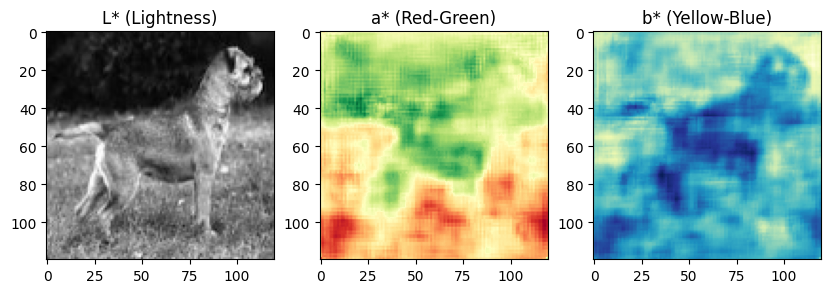

In [19]:

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    
axs[0].imshow(test_images_grayscale[0], cmap='gray')
axs[0].set_title('L* (Lightness)')

axs[1].imshow(ab_channels[:, :, 0], cmap='RdYlGn')
axs[1].set_title('a* (Red-Green)')

axs[2].imshow(ab_channels[:, :, 1], cmap='YlGnBu')
axs[2].set_title('b* (Yellow-Blue)')
    
plt.show()

### • Expected Channels

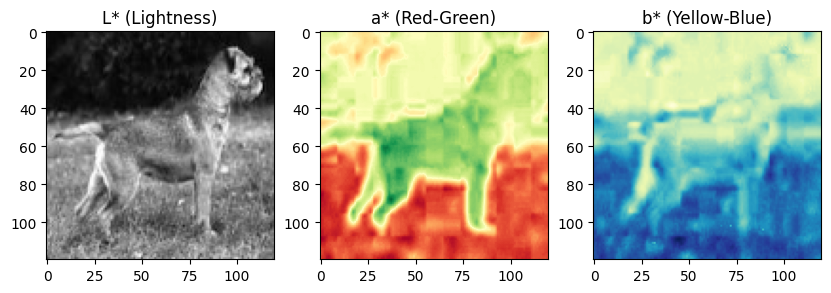

In [20]:
first_test_image_lab = val_dataset_lab_images[0]

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    
axs[0].imshow(first_test_image_lab[:, :, 0], cmap='gray')
axs[0].set_title('L* (Lightness)')

axs[1].imshow(first_test_image_lab[:, :, 1], cmap='RdYlGn')
axs[1].set_title('a* (Red-Green)')

axs[2].imshow(first_test_image_lab[:, :, 2], cmap='YlGnBu')
axs[2].set_title('b* (Yellow-Blue)')
    
plt.show()

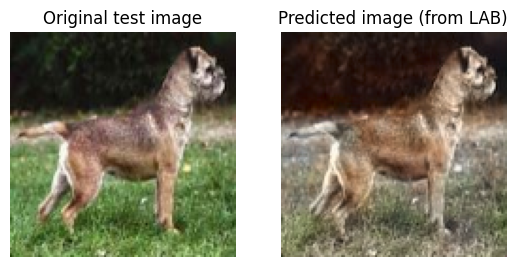

In [21]:
# Convert LAB to RGB
def lab_to_rgb(lab_img):
    rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)
    return rgb_img


#print(val_dataset_lab_images[0] == first_test_image_lab)

original_test_image_rgb = lab_to_rgb(first_test_image_lab)

# Plotting the RGB image converted from LAB
plt.subplot(1, 2, 1)

plt.imshow(cv2.cvtColor(original_test_image_rgb, cv2.COLOR_BGR2RGB))
plt.title("Original test image")
plt.axis('off')

plt.subplot(1, 2, 2)

first_test_image_lab[:, :, 1:] = ab_channels  # Replace AB channels in the original LAB image

predicted_image_rgb = lab_to_rgb(first_test_image_lab)

plt.imshow(cv2.cvtColor(predicted_image_rgb, cv2.COLOR_BGR2RGB))
plt.title("Predicted image (from LAB)")
plt.axis('off')





# Show the plots
#plt.tight_layout()
plt.show()